In [7]:
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
from google.colab import drive
import pickle
from IPython.display import display
from scipy.interpolate import griddata
import matplotlib.cm as cm
import matplotlib
import panel as pn

# Definzione delle costanti
IMG_DIR = '/content/drive/MyDrive/Uni/Magistrale/Sensori/Immagini 3D nuove/' # Cartella contenente le immagini
# Lista delle immagini
img_master_name = '25P.jpg' # Immagine solo master di taratura
img_laser_name = ['26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg'] # Immagini master con lama di luce a diverse quote

n_targets = 14 # Numero di righe dei target
m_targets = 21 # Numero di colonne dei target
target_step = 20 # Distanza centro centro tra un centroide e l'altro
main_target_num = 3 # Numero di centroidi principali

zsg = 0 # Quota iniziale

divisione_objp = {'righe': 0,
                  'colonne': 1,
                  'scacchiera': 2}

zsg_array = np.arange(0,10)

# Definzione della cartella di output nel drive
OUTDIR = '/content/drive/MyDrive/Uni/Magistrale/Sensori/Immagini 3D nuove/out/' # Cartella di output per salvare i risultati della taratura

# Importazione dei file presenti sulla cartella Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
 !pip install jupyter_bokeh

Dimensioni dell'immagine del master di taratura (height, width): (1080, 1920)


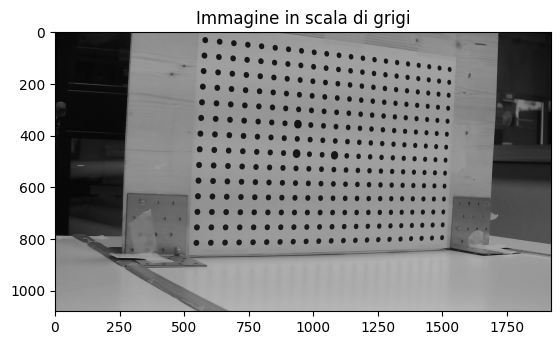

In [9]:
# Importazione dell'immagine del solo master di taratura
img_master = cv.imread(os.path.join(IMG_DIR, img_master_name), cv.IMREAD_COLOR)
assert img_master is not None, "ERRORE: File non trovato!"

h, w, _ = img_master.shape
print( f"Dimensioni dell'immagine del master di taratura (height, width): {(h,w)}" )

rgb_master = cv.cvtColor( img_master, cv.COLOR_BGR2RGB ) # Immagine a colori
gray_master = cv.cvtColor( img_master, cv.COLOR_BGR2GRAY ) # Immagine in scala di grigi, quella su cui si lavora

# Importazione delle immagini master di taratura con laser
img_laser = []
for name in img_laser_name:
  img_laser_temp = cv.imread(os.path.join(IMG_DIR, name), cv.IMREAD_COLOR)
  assert img_laser_temp is not None, "ERRORE: File non trovato!"
  img_laser.append(img_laser_temp)

# Plot immagine in scala di grigi del master di taratura
plt.imshow(gray_master, cmap='gray')
plt.title('Immagine in scala di grigi')
#plt.axis('off') # No assi
plt.show()

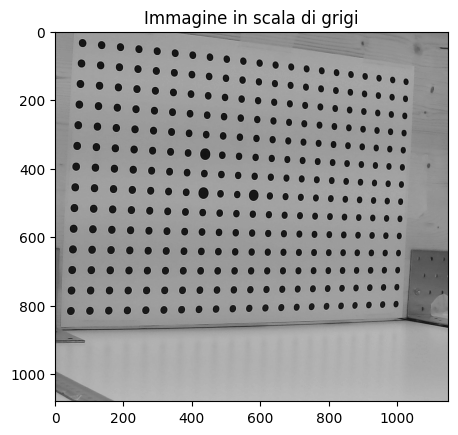

In [10]:
# Definizione della ROI (forse)
img_to_crop = gray_master.copy()
cropped_master = img_to_crop[:, 500:1650]

# Plot immagine in scala di grigi del master di taratura croppato
plt.imshow(cropped_master, cmap='gray')
plt.title('Immagine in scala di grigi')
#plt.axis('off') # No assi
plt.show()

Trovati 294 targets.
Identificati 2 cerchi principali.
Identificati 1 target principali.
Centro (da main_circles) : [931.5 472.5]
Centro (da centers_master) @ idx = 154 : [[932.9541 472.5346]]


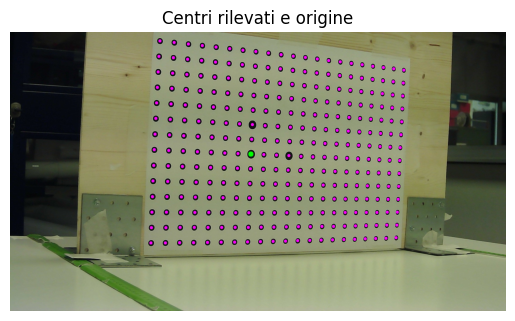

In [11]:
# Definizione del pattern per la determinazione dei target sul master di taratura
pattern = (m_targets, n_targets) # Tupla del pattern
image_dut = gray_master.copy() # Immagine di partenza è quella in scala di grigi

# Determinazione dei target
ret, centers_master = cv.findCirclesGrid(image_dut, pattern, flags=cv.CALIB_CB_SYMMETRIC_GRID)
assert centers_master is not None, "Nessun target trovato"

print(f"Trovati {len(centers_master)} targets.")

# Determinazione dei centroidi principali
# Ricerca dei target principali con algoritmo di Hough su un'immagine in scala di grigi
dp = 3
minDistance = 25
minRadius = 8
maxRadius = 22
circles = cv.HoughCircles(image_dut, cv.HOUGH_GRADIENT, dp, minDistance, minRadius=minRadius, maxRadius=maxRadius )
print( f"Identificati {len(circles[0])} cerchi principali.")
assert circles is not None, "Nessun target trovato" # Verifica che l'array di mainTargets non sia vuoto

delta1 = delta2 = 0.5
mainTargets = []

# Determinazione dei target principali tramite metodo statistico
if circles is not None:
    r_mean = np.mean( circles[0][:,[2]] ) # Determinazione della media dei raggi dei cerchi identificati
    r_std = np.std( circles[0][:,[2]] ) #  Determinazione della dev. standard dei raggi dei cerchi identificati

    for circle in circles[0,:]:
        center = np.uint16([circle[0], circle[1]]) # Estrazione degli array delle coordinate (i,j) di ciascun cerchio
        radius = np.uint16(circle[2]) # Estrazione dei raggi di ciascun cerchio

        if ( radius >= (r_mean + delta1*r_std) ):
            mainTargets.append( [circle[0], circle[1], circle[2]] )


print( f"Identificati {len(mainTargets)} target principali.") # Dovrebbero essere solo tre
assert mainTargets is not None, "Nessun target trovato" # Verifica che l'array di mainTargets non sia vuoto

# Determinazione del target principale (quello in basso a sx) che sarà il nostro origine
mainTargets = np.array( mainTargets )
mean_i = np.mean(mainTargets[:,0] ) # Effettua la media della i dei centri dei target principali
edges_i = np.array([0,mean_i,w]) # Crea array di tre elementi: 0, media della i dei centri e w, la larghezza dell'immagine
idxs_i = np.digitize(mainTargets[:,0], edges_i) # Crea un'indicizzazione dei punti principali sulla base della media della i.

bin_i = 0
if sum( idxs_i == 1 ) == 2: # Se il numero di mainTarget sotto la media è pari a 2
    bin_i = 1
else:
    bin_i = 2

ypts = mainTargets[idxs_i==bin_i,:] # Estrae i due punti principali presenti sull'asse verticale 'y', che avranno lo stesso valore (circa) di i (ascissa)

# Stessa operazione di prima, ma con le coordinate j
mean_j = np.mean( mainTargets[:,1] )
edges_j = np.array( [0,mean_j,h])
idxs_j = np.digitize( mainTargets[:,1], edges_j  )

bin_j = 0
if sum( idxs_j == 1 ) == 2:
    bin_j = 1
else:
    bin_j = 2

xpts = mainTargets[idxs_j==bin_j,:] # Estrae i punti principali presenti sull'asse orizzontale 'x', che avranno la stesso valore (circa) di j (ordinata)

mainCircle = np.array( [np.mean( ypts[:,0] ), np.mean( xpts[:,1] ) ] ) # Il punto principale è composto dalla media dei center_i e center_j
print( f"Centro (da main_circles) : {mainCircle}" )

# Verifica
iCenter = np.linalg.norm(centers_master - np.ones( centers_master.shape )*mainCircle, axis=2).argmin() # indice del riferimento
print( f"Centro (da centers_master) @ idx = {iCenter} : {centers_master[iCenter]}" )

# Plot dell'immagine
cdst = rgb_master.copy()

if centers_master is not None: # tutti i centroidi
    for center in centers_master:
        cv.circle( cdst, center[0].astype('int16'), 6, (255,0,255), -1 )
    #for circle in circles[0]:
    #    cv.circle( cdst, [circle[0].astype('int16'), circle[1].astype('int16')], circle[2].astype('int16'), (0, 127, 255), -1)

cv.circle(cdst,  np.uint16(centers_master[iCenter])[0], 10, (0, 255, 0), -1)

plt.imshow(cdst)
plt.title('Centri rilevati e origine')
plt.axis('off')
plt.show()

In [12]:
# creo una lista contenente la posizione reale di ogni centroide in x,y,z con z=0

objpts_global = np.zeros((m_targets*n_targets,3), np.float32) # creo la lista vuota
objpts_global[:,:2] = np.mgrid[0:m_targets,0:n_targets].T.reshape(-1,2) # alla lista metto le coo x e y unitarie x,y,z

objpts_global[:] = objpts_global[:] - objpts_global[iCenter,:] # dal centro calcolato sopra prendo gli x-y di quell'indice e lo sottraggo a tutta la lista
                                            # sto traslando il tutto renenedo l'indice 72 il 0-0
# moltiplico la x e y per la distanza tra i centri per ottenere l'effettiva posizione di ogni centro in mm
objpts_global[:,0] = objpts_global[:,0]*target_step
objpts_global[:,1] = -1*objpts_global[:,1]*target_step # la y è ribaltata quindi la raddrizzo con il -1,

In [13]:
# Creazione del pannello selettore per decidere in che modo suddividere objp di calibrazione e di test
pn.extension()
selection = pn.widgets.Select(name='Suddivisione objpoints', options=divisione_objp)

selection.value = divisione_objp['scacchiera']

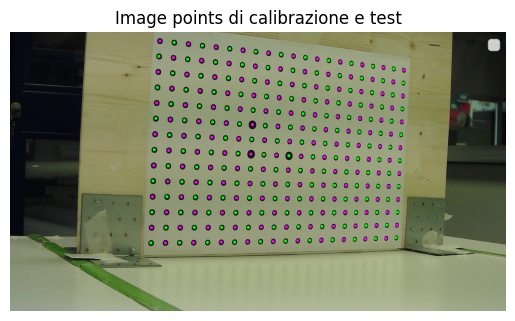

In [14]:
# Estrazione delle colonne e righe a scacchiera. Una per calibrazione e una per il test
objp = objpts_global.reshape(n_targets, m_targets, 3)
imgp = centers_master.reshape(n_targets, m_targets, 2)

if(selection.value == divisione_objp['righe']):
    objpCal = objp[::2] # Righe pari
    objpTest = objp[1::2] # Righe dispari
    imgpCal = imgp[::2] # Righe pari
    imgpTest = imgp[1::2] # Righe dispari
elif(selection.value == divisione_objp['colonne']):
    objp = objpts_global.reshape(n_targets, m_targets, 3)
    imgp = centers_master.reshape(n_targets, m_targets, 2)
    objpCal = objp[:,::2] # Colonne pari
    objpTest = objp[:,1::2] # Colonne dispari
    imgpCal = imgp[:, ::2] # Righe pari
    imgpTest = imgp[:, 1::2] # Righe dispari
elif(selection.value == divisione_objp['scacchiera']):
    objpCal = objpts_global[::2] # Indici pari
    objpTest = objpts_global[1::2] # Indici dispari
    imgpCal = centers_master[::2] # Indici pari
    imgpTest = centers_master[1::2] # Indici dispari

# riporto i dati in array
objpCal_glob = objpCal.reshape(-1,3)
objpTest_glob = objpTest.reshape(-1,3)

# riporto i dati in array
imgpCal_glob = imgpCal.reshape(-1,2)
imgpTest_glob = imgpTest.reshape(-1,2)

# Plot degli imgp_list di calibrazione e test
cdst = rgb_master.copy()
if imgpCal is not None: # calibrazione
    for cal in imgpCal_glob:
        cv.circle( cdst, cal.astype('int16'), 6, (255,0,255), -1 )

if imgpTest is not None: # verifica
    for test in imgpTest_glob:
        cv.circle( cdst, test.astype('int16'), 6, (0,255,0), -1 )

plt.imshow(cdst)
plt.title('Image points di calibrazione e test')
plt.legend(['Calibrazione', 'Test'])
plt.axis('off')
plt.show()

In [15]:
Q = []
d = []
for i in range( objpCal_glob.shape[0] ):
    op = objpCal_glob[i]   #[x_sg, y_sg, z_sg]
    ip = imgpCal_glob[i]

    i_s = ip[0]
    j_s = ip[1]

    Q.append(np.concatenate( [op, [1,0,0,0,0], -1*op*i_s] ))
    Q.append(np.concatenate( [[0,0,0,0], op, [1], -1*op*j_s]))

    d.append( i_s )
    d.append( j_s )

Q=np.array(Q)
d=np.array(d)

m = np.dot( np.linalg.pinv( Q ), d )
display(m)
gamma2 = m[8]**2 + m[9]**2 + m[10]**2
tz = np.sqrt( 1/gamma2 )

P = np.reshape( np.concatenate( [m,[1]] )*tz, (3,4) )

display( P )
display( tz )


xyz_im=[]

diff_x=[]
diff_y=[]


for i in range( len(imgpTest_glob) ):
    zG=0
    xy_ob = objpTest_glob[i]

    is_im = imgpTest_glob[i][0]
    js_im = imgpTest_glob[i][1]


    A_K=[ [m[0]-m[8]*is_im, m[1]-m[9]*is_im], [m[4]-m[8]*js_im, m[5]-m[9]*js_im]  ]
    b_K=np.array([[is_im-(m[2]-m[10]*is_im)*zG-m[3], js_im-(m[6]-m[10]*js_im)*zG-m[7]]]).T
    xy_im_i=np.linalg.solve(A_K,b_K)
    xyz_im.append(xy_im_i)

    diff_x_i=xy_im_i[0]-xy_ob[0]
    diff_x.append(diff_x_i)
    diff_y_i=xy_im_i[1]-xy_ob[1]
    diff_y.append(diff_y_i)

array([ 2.95609847e+00,  1.23049372e-01,  1.18032605e-08,  9.34366868e+02,
        3.41237238e-01, -2.82869898e+00,  1.37514954e-13,  4.72412968e+02,
        4.91366017e-04, -3.63656412e-07,  0.00000000e+00])

array([[ 6.01608079e+03,  2.50422971e+02,  2.40213137e-05,
         1.90156946e+06],
       [ 6.94466308e+02, -5.75680472e+03,  2.79862489e-10,
         9.61427575e+05],
       [ 9.99999726e-01, -7.40092517e-04,  0.00000000e+00,
         2.03514222e+03]])

2035.142217229872

In [16]:
# Calcolo statistico degli errori
mean_error_x = np.mean(np.abs(diff_x))
std_error_x = np.std(np.abs(diff_x))
min_error_x = np.min(np.abs(diff_x))
max_error_x = np.max(np.abs(diff_x))

mean_error_y = np.mean(np.abs(diff_y))
std_error_y = np.std(np.abs(diff_y))
min_error_y = np.min(np.abs(diff_y))
max_error_y = np.max(np.abs(diff_y))

results_x = [mean_error_x, std_error_x, min_error_x, max_error_x]
results_y = [mean_error_y, std_error_y, min_error_y, max_error_y]

print('-------------------------------------')
print(f'Errore medio in x: {mean_error_x} mm')
print(f'Deviazione standard in x: {std_error_x}')
print(f'Errore minimo in x: {min_error_x} mm')
print(f'Errore massimo in x: {max_error_x} mm')
print('-------------------------------------')
print(f'Errore medio in y: {mean_error_y} mm')
print(f'Deviazione standard in y: {std_error_y}')
print(f'Errore minimo in y: {min_error_y} mm')
print(f'Errore massimo in y: {max_error_y} mm')

-------------------------------------
Errore medio in x: 0.30911462368029813 mm
Deviazione standard in x: 0.23550168709174601
Errore minimo in x: 0.0003091471869538509 mm
Errore massimo in x: 1.045595836206914 mm
-------------------------------------
Errore medio in y: 0.2157000451364363 mm
Deviazione standard in y: 0.19060621143709408
Errore minimo in y: 0.004982144698004731 mm
Errore massimo in y: 1.2034605038661397 mm


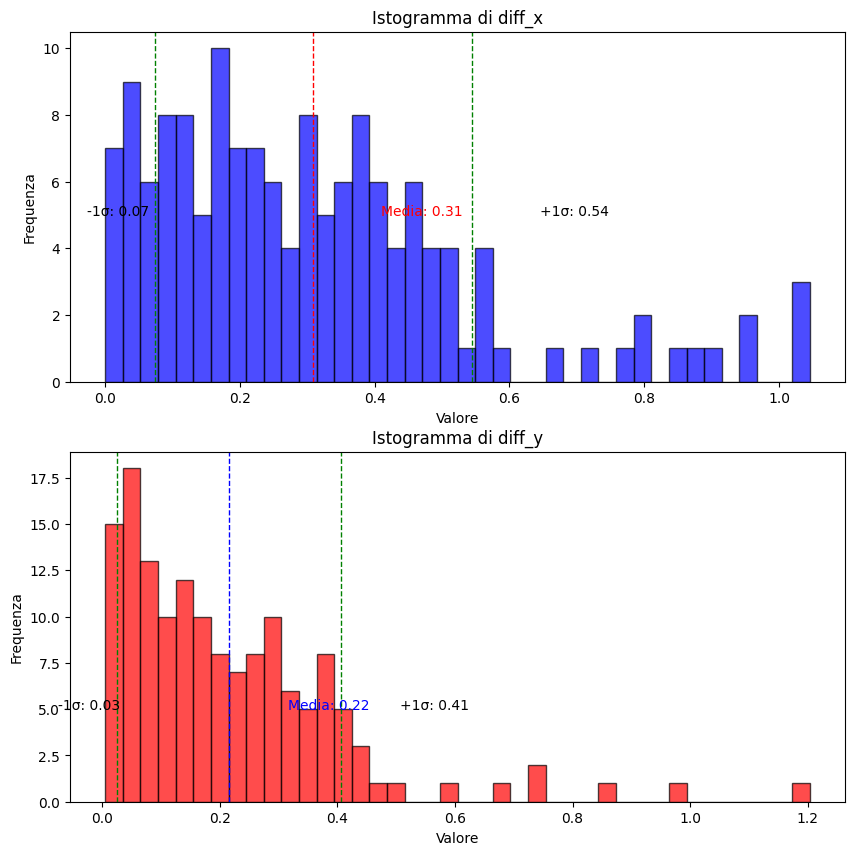

In [17]:
# Preparazione
if isinstance(diff_x, list):
    diff_x = np.concatenate(diff_x)

if isinstance(diff_y, list):
    diff_y = np.concatenate(diff_y)


# Rappresentazione errori tramite istogramma
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.hist(np.abs(diff_x), bins=40, color='blue', alpha=0.7, edgecolor='black')
ax1.axvline(mean_error_x, color='red', linestyle='dashed', linewidth=1)
ax1.text(mean_error_x + 0.1, 5, f'Media: {mean_error_x:.2f}', color='red')
ax1.axvline(mean_error_x + std_error_x, color='green', linestyle='dashed', linewidth=1)
ax1.axvline(mean_error_x - std_error_x, color='green', linestyle='dashed', linewidth=1)
ax1.text(mean_error_x + std_error_x + 0.1, 5, f'+1σ: {mean_error_x + std_error_x:.2f}', color='black')
ax1.text(mean_error_x - std_error_x - 0.1, 5, f'-1σ: {mean_error_x - std_error_x:.2f}', color='black')
ax1.set_xlabel('Valore')
ax1.set_ylabel('Frequenza')
ax1.set_title('Istogramma di diff_x')

ax2.hist(np.abs(diff_y), bins=40, color='red', alpha=0.7, edgecolor='black')
ax2.axvline(mean_error_y, color='blue', linestyle='dashed', linewidth=1)
ax2.text(mean_error_y + 0.1, 5, f'Media: {mean_error_y:.2f}', color='blue')
ax2.axvline(mean_error_y + std_error_y, color='green', linestyle='dashed', linewidth=1)
ax2.axvline(mean_error_y - std_error_y, color='green', linestyle='dashed', linewidth=1)
ax2.text(mean_error_y + std_error_y + 0.1, 5, f'+1σ: {mean_error_y + std_error_y:.2f}', color='black')
ax2.text(mean_error_y - std_error_y - 0.1, 5, f'-1σ: {mean_error_y - std_error_y:.2f}', color='black')
ax2.set_xlabel('Valore')
ax2.set_ylabel('Frequenza')
ax2.set_title('Istogramma di diff_y')
plt.show()

In [18]:
# Estrazione delle variabili e salvataggio su file Drive
def vardump( var, fname ):
    with open(fname, 'wb') as fw:
        pickle.dump( var, fw )

vardump( P, os.path.join( OUTDIR, 'matrixP.dump') )
vardump( m, os.path.join( OUTDIR, 'matrixM.dump'))
vardump( results_x, os.path.join( OUTDIR, 'resultsX.dump') )
vardump( results_y, os.path.join( OUTDIR, 'resultsY.dump') )